In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from propagation import laser
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Experimental/1inAxicon/'

In [2]:
# Create a laser beam, pulse and axicon lens
lam = 0.8
pulseParams = {'Nx' : 2**12,
               'Ny' : 2**11,
               'Nt' : 2**6,
               'X' : 28e3,
               'Y' : 28e3,
               'T' : 100,
               'lam' : lam,
               'path' : path,
               'name' : 'FlattopBeam',
               'threads' : 4,
               'cyl' : False,
               'tau' : 50,
               'load' : False}

beam = laserbeam.Laser(pulseParams)
pulseParams['name'] = 'FlattopPulse'
pulse = laserpulse.Pulse(pulseParams)

plasmaParams = {'Nx' : pulseParams['Nx'],
                'Ny' : pulseParams['Ny'],
                'Nz' : 2**8,
                'X' : pulseParams['X'],
                'Y' : pulseParams['Y'],
                'Z' : 2.0e6,
                'n0': 1.0,
                'atom' : ionization.Ar,
                'path' : path,
                'name' : 'Plasma',
                'cyl' : False,
                'load' : False}

argon = plasma.UniformPlasma(plasmaParams)

alpha = 1.0
n = 1.458
beta = np.degrees(np.arcsin(n*np.sin(np.radians(alpha)))) - alpha
print('Axicon deflection angle : %0.3f deg' % beta)
lensParams = {'Nx' : pulseParams['Nx'],
              'Ny' : pulseParams['Ny'],
              'X' : pulseParams['X'],
              'Y' : pulseParams['Y'],
              'path' : path,
              'name' : 'Axicon',
              'lam' : lam,
              'beta' : beta,
              'load' : False}
axicon = optic.AxiconLens(lensParams)

apertureParams = {'Nx' : pulseParams['Nx'],
                  'Ny' : pulseParams['Ny'],
                  'X' : pulseParams['X'],
                  'Y' : pulseParams['Y'],
                  'path' : path,
                  'name' : 'Aperturen',
                  'lam' : lam,
                  'r' : 25.4e3/2,
                  'load' : False}

aperture = optic.Aperture(apertureParams)

Axicon deflection angle : 0.458 deg


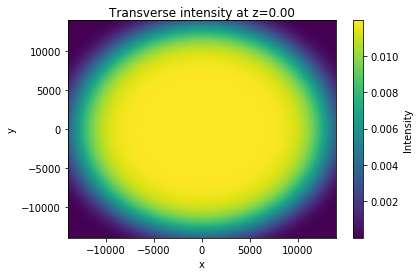

Power: 6.08325818756


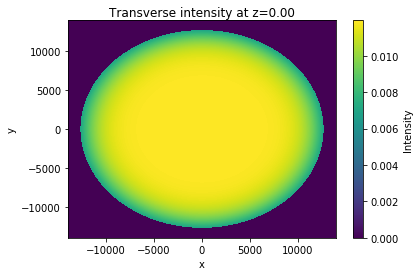

In [3]:
# Create a super gaussian intensity profile and pass it through a lens.
w0 = 15e3
E0 = 3.0
n = 8
x2 = np.reshape(beam.x, (beam.Nx, 1))**2
y2 = np.reshape(beam.y, (1, beam.Ny))**2
r = np.sqrt(x2 + y2)
e = E0 * np.exp(-(r/w0)**n)

beam.initialize_field(e)

e = e[None, :, :] * np.exp(-pulse.t[:, None, None]**2 * np.pi/(2*pulse.tau**2))
pulse.initialize_field(e)
beam.plot_current_intensity()
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                         beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
interactions.beam_phase(beam, axicon)
interactions.beam_intensity(beam, aperture)
beam.plot_current_intensity()

In [4]:
beam.propagate(np.linspace(0, plasmaParams['Z'], plasmaParams['Nz']), 1.0)

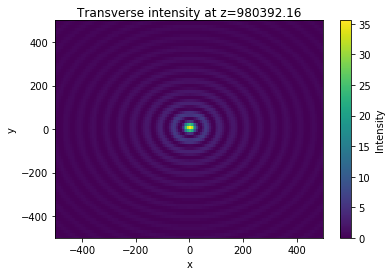

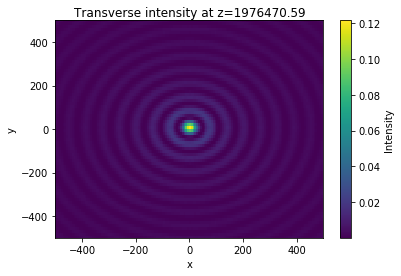

In [11]:
lim = [-500, 500]
#lim = [-5e3, 5e3]
#beam.plot_intensity_at(int(plasmaParams['Nz']/4), lim=lim)
beam.plot_intensity_at(int(plasmaParams['Nz']/2), lim=lim)
beam.plot_intensity_at(plasmaParams['Nz']-1, lim=lim)

In [7]:
# Load the longitudinal field
Nx = pulseParams['Nx']
Nz = plasmaParams['Nz']
X = pulseParams['X']
Z = plasmaParams['Z']
e = np.zeros((Nx, Nz-1), dtype='complex128')
for i in range(1, Nz):
    e[:, i-1] = beam.load_field(i)[0][:, int(pulseParams['Ny']/2)]

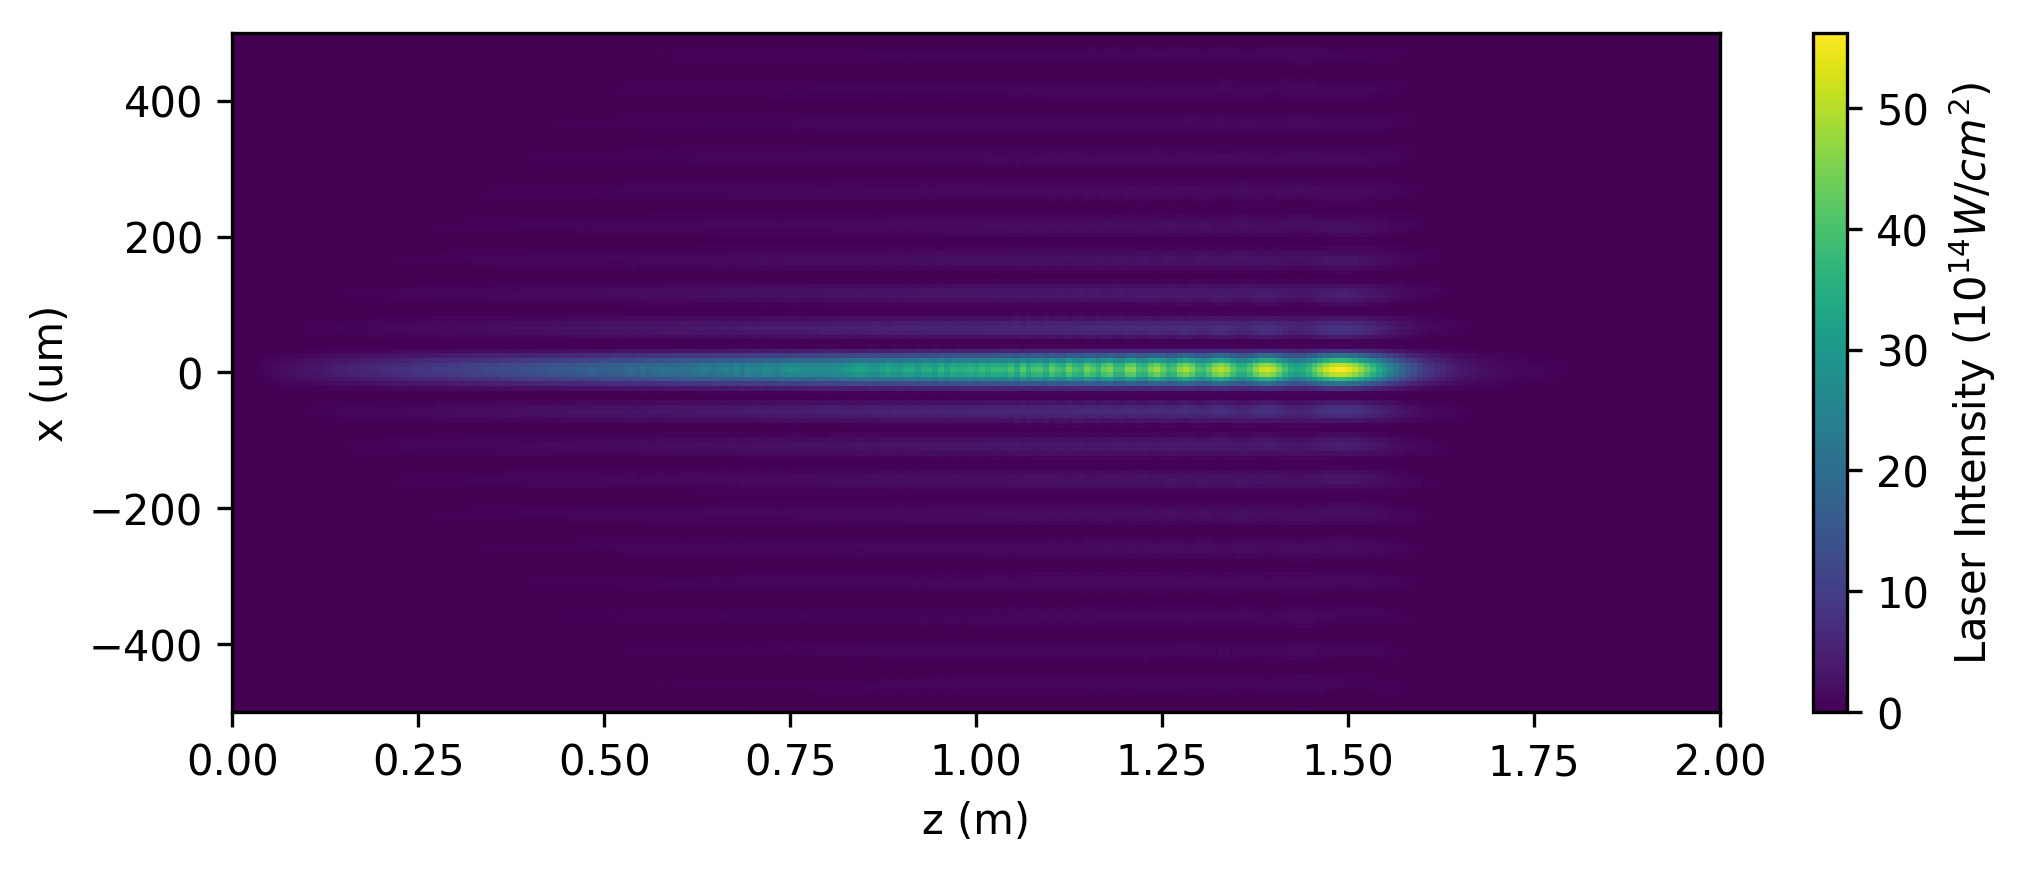

In [8]:
# Plot the longitudinal intensity
plt.figure(figsize=(8, 3), dpi=300)
plt.imshow(np.flipud(beam.intensity_from_field(e)), aspect='auto', extent=[0, Z/1e6, -X/2, X/2], cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.ylim(-500, 500)
plt.xlabel(r'z (m)')
plt.ylabel(r'x (um)')
plt.show()

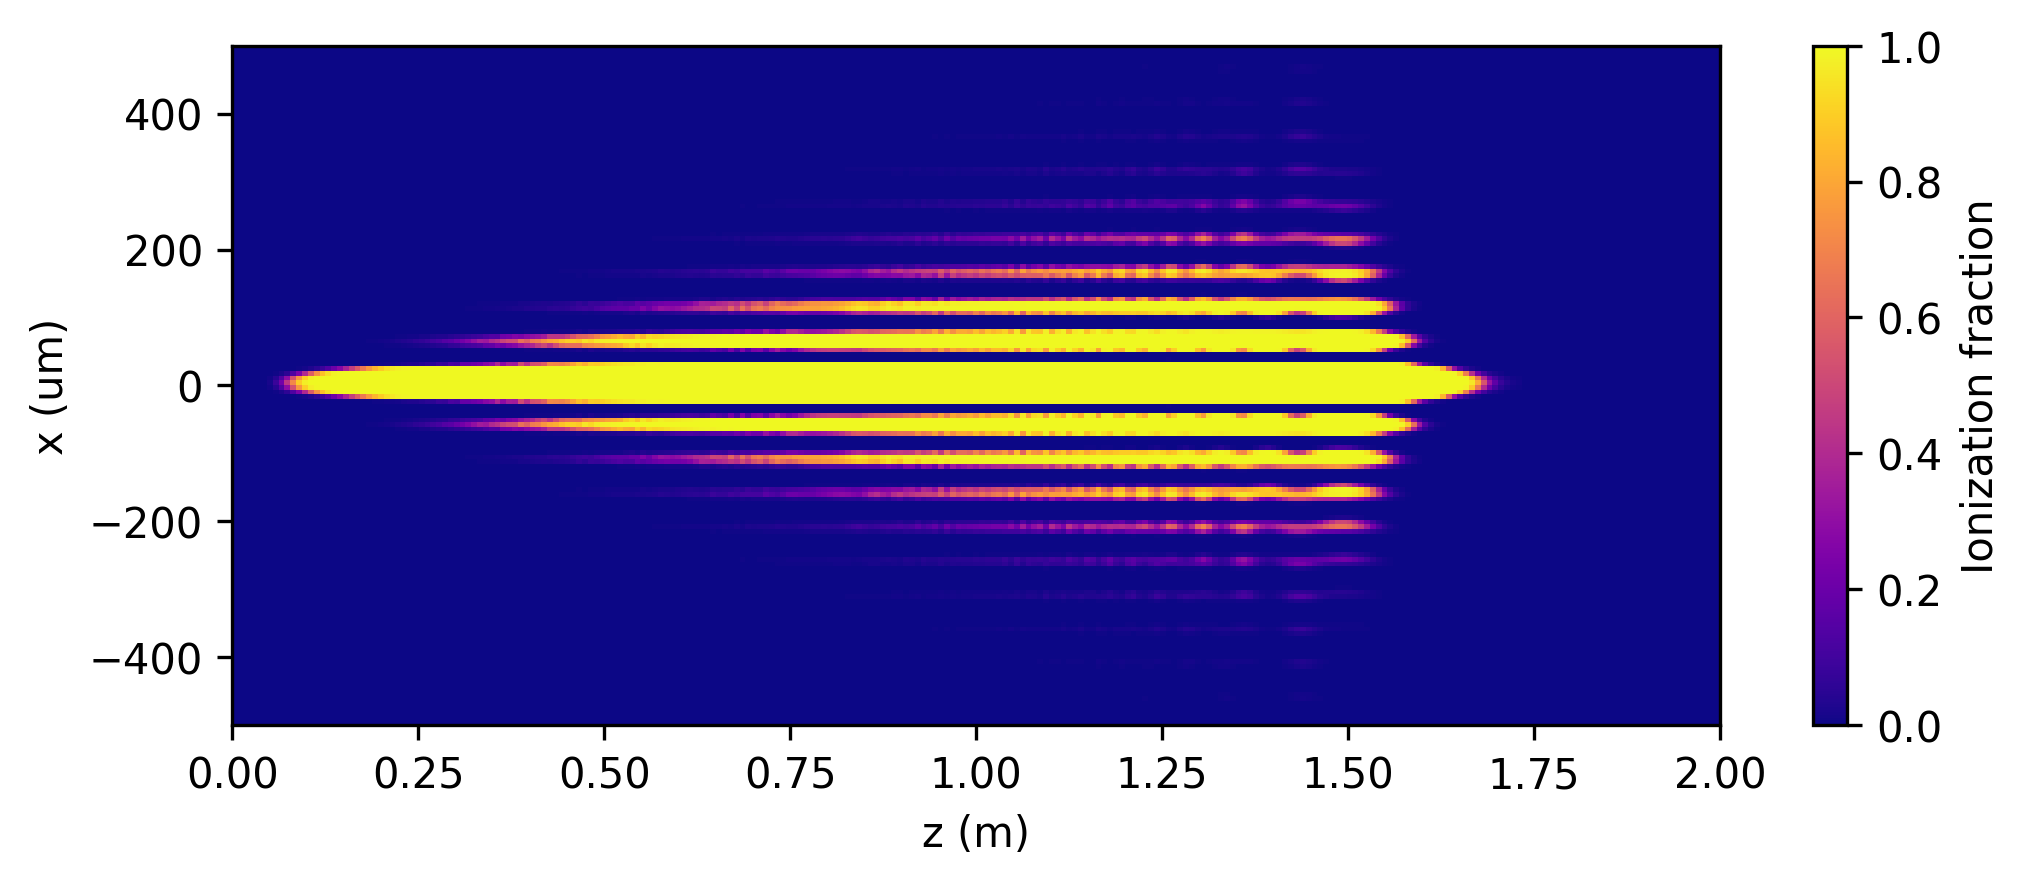

In [9]:
# Lets check the plasma density without refraction in Ar
atom = ionization.Ar
ne = adk.gaussian_frac(atom['EI'], abs(e), pulseParams['tau'], atom['Z'], atom['l'], atom['m'])
plt.figure(figsize=(8, 3), dpi=300)
plt.imshow(np.flipud(ne), aspect='auto', extent=[0, Z/1e6, -X/2, X/2], cmap='plasma')
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.ylim(-500, 500)
plt.xlabel(r'z (m)')
plt.ylabel(r'x (um)')
plt.show()

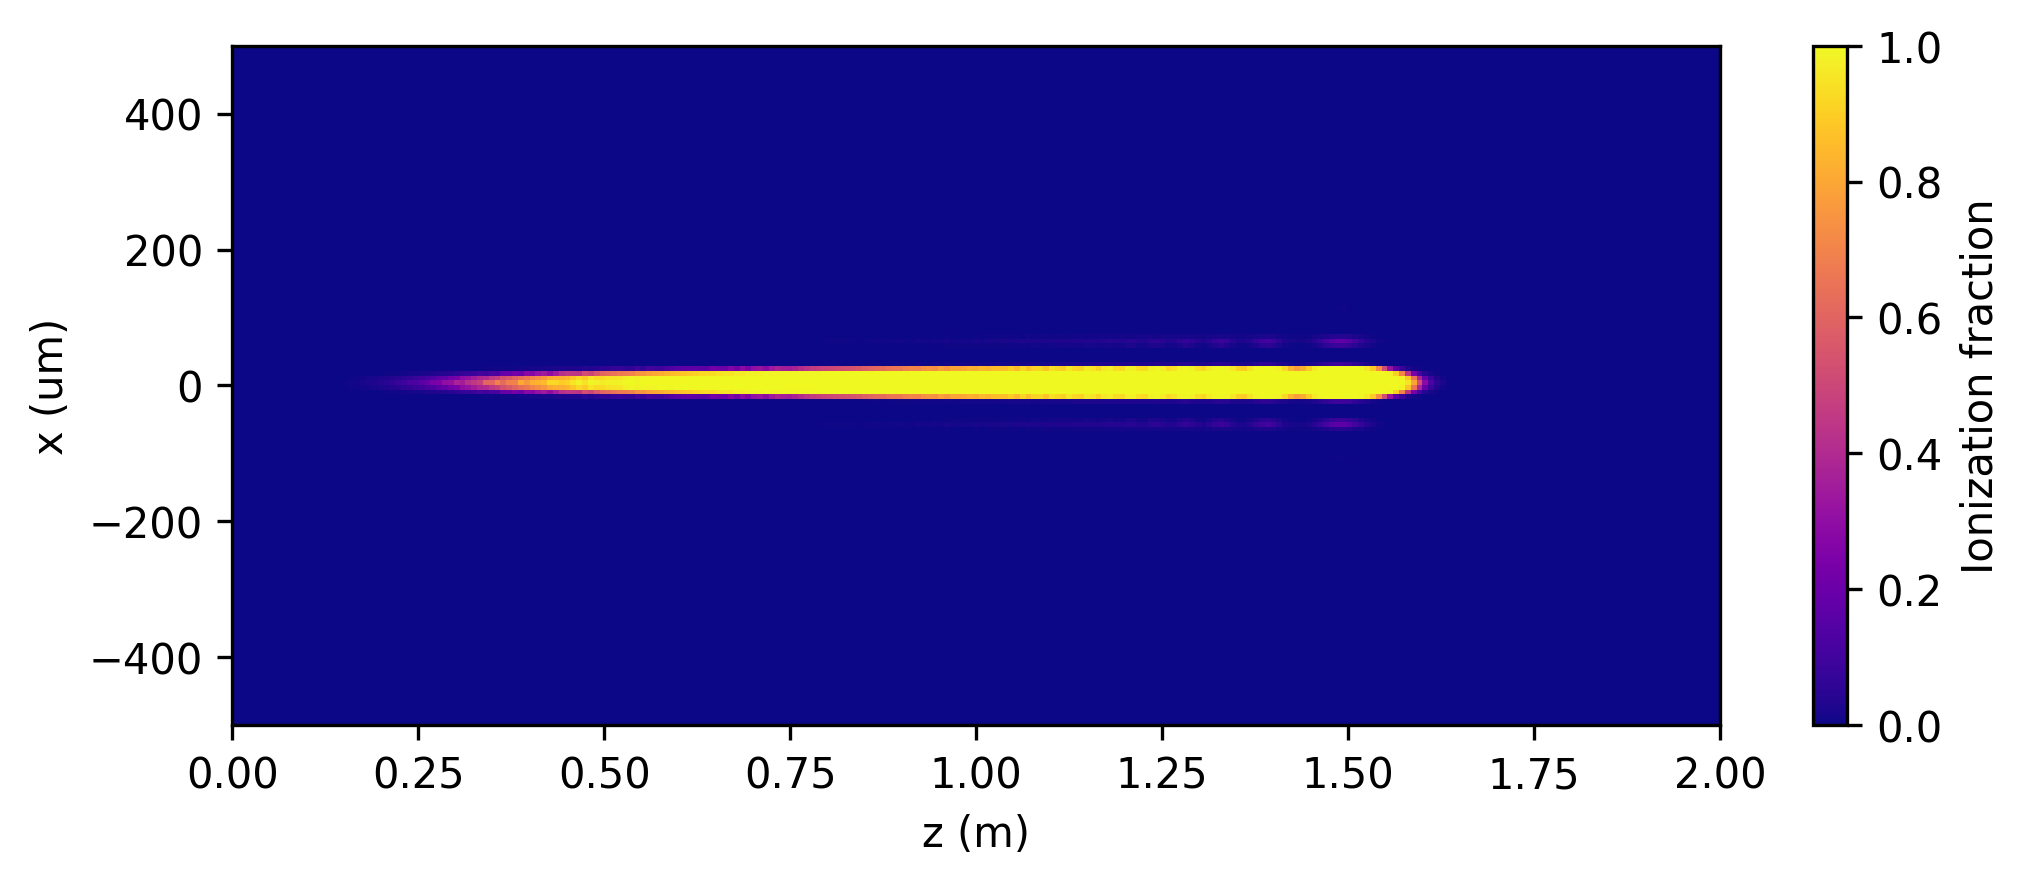

In [10]:
# Lets check the plasma density without refraction in He
atom = ionization.He
ne = adk.gaussian_frac(atom['EI'], abs(e), pulseParams['tau'], atom['Z'], atom['l'], atom['m'])
plt.figure(figsize=(8, 3), dpi=300)
plt.imshow(np.flipud(ne), aspect='auto', extent=[0, Z/1e6, -X/2, X/2], cmap='plasma')
cb = plt.colorbar()
cb.set_label(r'Ionization fraction')
plt.ylim(-500, 500)
plt.xlabel(r'z (m)')
plt.ylabel(r'x (um)')
plt.show()

In [ ]:
interactions.pulse_plasma(pulse, argon)